In [46]:
import pandas as pd
import numpy as np
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer


%matplotlib inline

In [47]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score

In [48]:
df= pd.read_csv('train  (1) .csv')

## Basic EDA

In [49]:
df.head(5)

,unique ID,query_text,category
0,0,HTTPS://VIMEO.COM/107297364﻿,junk
1,1,Art and Culture,general
2,2,Differentiate between chemical and biological ...,academic_servable
3,3,nth Term of an AP,academic_servable
4,4,bunmei kaika: aoiza ibunroku saien,junk


In [50]:
df.isnull().sum()

unique ID     0
query_text    0
category      0
dtype: int64

In [51]:
total_word_count = 0
for text in df['query_text']:
    total_word_count += len(text.split(' '))
total_word_count

83817

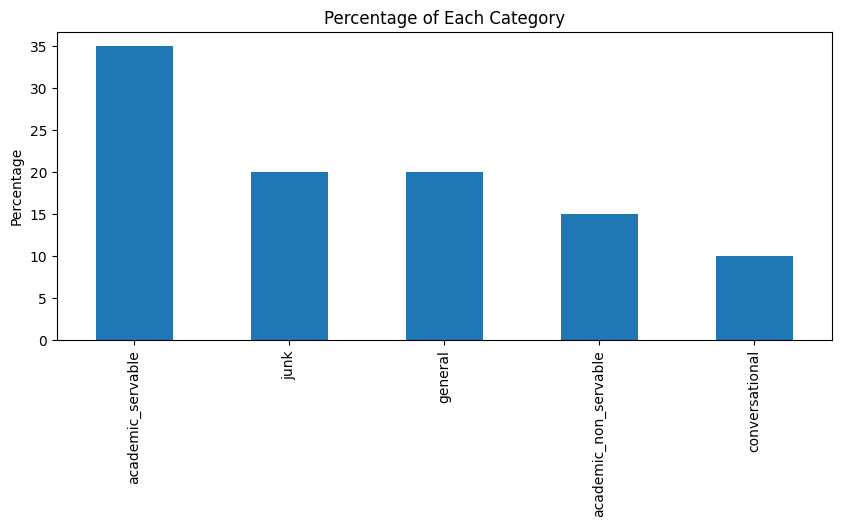

In [52]:
import matplotlib.pyplot as plt

category_counts = df['category'].value_counts()
total_samples = len(df)
category_percentages = (category_counts / total_samples) * 100

plt.figure(figsize=(10, 4))
category_percentages.plot(kind='bar')
plt.ylabel('Percentage')
plt.title('Percentage of Each Category')
plt.show()


## Feature Engineering

In [53]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'\W+', ' ', text)     # Remove non-alphanumeric characters
    text = text.lower()                  # Convert text to lowercase
    text = re.sub(r'[^\w\s,]', '', text) # Remove emojis
    return text


In [ ]:
df['query_text'] = df['query_text'].apply(preprocess_text)

In [54]:
def tokenize_and_process(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    return ' '.join(lemmatized_tokens)  # Convert tokens back to text

In [55]:
df['query_text'] = df['query_text'].apply(tokenize_and_process)

In [56]:
X = df['query_text']
y = df['category']

In [57]:
vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(X)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X_tfidf, y, test_size=0.30, random_state=42)

## Doing OverSampling on Data

In [59]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)

X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)


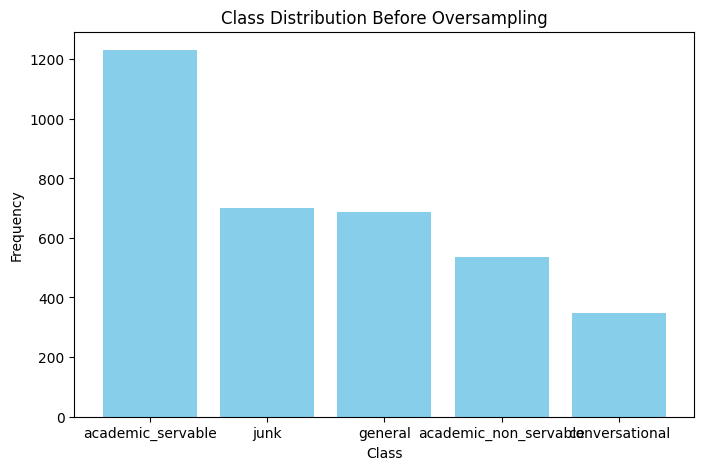

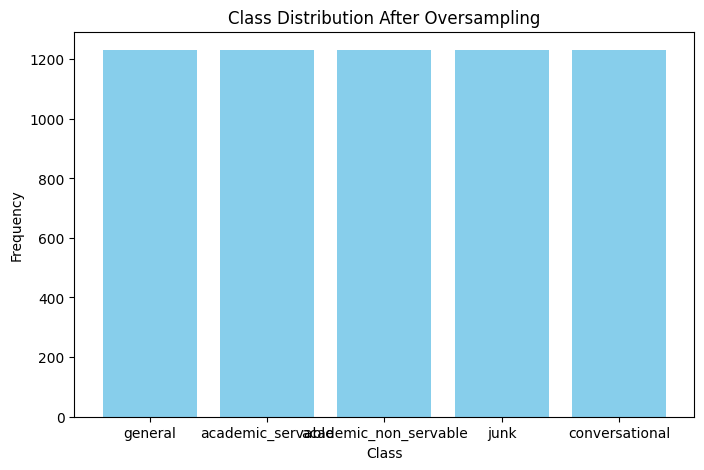

In [60]:
import matplotlib.pyplot as plt

def plot_class_distribution(y, title):
    class_counts = y.value_counts()
    class_labels = class_counts.index
    plt.figure(figsize=(8, 5))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

plot_class_distribution(y_train, title='Class Distribution Before Oversampling')

plot_class_distribution(y_train_balanced, title='Class Distribution After Oversampling')


## Applying Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_balanced, y_train_balanced)
y_pred = nb_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.6326666666666667
Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       0.51      0.94      0.66       215
    academic_servable       0.78      0.45      0.57       519
       conversational       0.58      0.78      0.66       153
              general       0.70      0.70      0.70       313
                 junk       0.62      0.59      0.60       300

             accuracy                           0.63      1500
            macro avg       0.64      0.69      0.64      1500
         weighted avg       0.67      0.63      0.63      1500



In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_test_encoded = label_encoder.transform(y_test)


In [ ]:
y_test_encoded = label_encoder.transform(y_test)

## Applying multiple Ensemble methods

In [ ]:
best_logistic_regression = LogisticRegression(C=10, solver='liblinear')
best_svc = SVC(C=1, gamma='scale', kernel='linear')
best_kneighbors = KNeighborsClassifier(algorithm='auto', n_neighbors=3, weights='distance')
best_decision_tree = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=2)
best_random_forest = RandomForestClassifier(bootstrap=False, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=300)

best_logistic_regression.fit(X_train_balanced, y_train_balanced)
best_svc.fit(X_train_balanced, y_train_balanced)
best_kneighbors.fit(X_train_balanced, y_train_balanced)
best_decision_tree.fit(X_train_balanced, y_train_balanced)
best_random_forest.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(bootstrap=False, max_features='log2',
                       min_samples_split=10, n_estimators=300)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def print_metrics(model, X_train_balanced, y_train_balanced, X_test, y_test_encoded):
    train_predictions = model.predict(X_train_balanced)
    train_accuracy = accuracy_score(y_train_balanced, train_predictions)
    train_report = classification_report(y_train_balanced, train_predictions)

    test_predictions = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_predictions)
    test_report = classification_report(y_test, test_predictions)

    print(f"Training Accuracy: {train_accuracy}")
    print("Training Classification Report:")
    print(train_report)

    print("\n" + "="*50 + "\n")

    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(test_report)

print("Logistic Regression Metrics:")
print_metrics(best_logistic_regression, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

print("\nSVC Metrics:")
print_metrics(best_svc, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

print("\nK-Neighbors Classifier Metrics:")
print_metrics(best_kneighbors, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

print("\nDecision Tree Classifier Metrics:")
print_metrics(best_decision_tree, X_train_balanced, y_train_balanced, X_test, y_test_encoded)

print("\nRandom Forest Classifier Metrics:")
print_metrics(best_random_forest, X_train_balanced, y_train_balanced, X_test, y_test_encoded)


Logistic Regression Metrics:
Training Accuracy: 0.9863525588952071
Training Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       1.00      0.99      1.00      1231
    academic_servable       0.99      0.96      0.98      1231
       conversational       0.99      1.00      0.99      1231
              general       0.99      1.00      1.00      1231
                 junk       0.96      0.99      0.97      1231

             accuracy                           0.99      6155
            macro avg       0.99      0.99      0.99      6155
         weighted avg       0.99      0.99      0.99      6155



Test Accuracy: 0.72
Test Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       0.85      0.80      0.82       215
    academic_servable       0.75      0.74      0.74       519
       conversational       0.68      0.58      0.63       153
              general       

In [ ]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('stopwords')
nltk.download('wordnet')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Creating model pipeline

In [64]:
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'\d+', '', text)      # Remove numbers
    text = re.sub(r'\W+', ' ', text)     # Remove non-alphanumeric characters
    text = text.lower()                  # Convert text to lowercase
    text = re.sub(r'[^\w\s,]', '', text) # Remove emojis
    return text

def tokenize_and_process(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    stemmer = SnowballStemmer('english')
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    return ' '.join(lemmatized_tokens)

df = pd.read_csv('train  (1) .csv')

df['query_text'] = df['query_text'].apply(preprocess_text)
df['query_text'] = df['query_text'].apply(tokenize_and_process)

X = df['query_text']
y = df['category']

vectorizer = TfidfVectorizer()

X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.30, random_state=42)

oversampler = RandomOverSampler(random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)

random_forest_classifier = RandomForestClassifier(bootstrap=False, max_depth=None, max_features='log2', min_samples_leaf=1, min_samples_split=10, n_estimators=300)
random_forest_classifier.fit(X_train_balanced, y_train_balanced)

def make_predictions_and_print_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(report)

make_predictions_and_print_metrics(random_forest_classifier, X_test, y_test)


Accuracy: 0.7026666666666667
Classification Report:
                       precision    recall  f1-score   support

academic_non_servable       0.92      0.76      0.83       215
    academic_servable       0.74      0.72      0.73       519
       conversational       0.67      0.59      0.63       153
              general       0.82      0.64      0.72       313
                 junk       0.52      0.75      0.61       300

             accuracy                           0.70      1500
            macro avg       0.73      0.69      0.70      1500
         weighted avg       0.73      0.70      0.71      1500



## Testing model on test.csv

In [ ]:
import joblib

joblib.dump(random_forest_classifier, 'random_forest_classifier.pkl')

['random_forest_classifier.pkl']

In [77]:
import pandas as pd
import joblib

random_forest_classifier = joblib.load('random_forest_classifier.pkl')

# Read the test data
test_df = pd.read_csv('test (2).csv')

test_df['query_text'] = test_df['query_text'].apply(preprocess_text)
test_df['query_text'] = test_df['query_text'].apply(tokenize_and_process)

X_test_tfidf = vectorizer.transform(test_df['query_text'])

predictions = random_forest_classifier.predict(X_test_tfidf)

submission_df = pd.DataFrame({'unique ID': test_df.index, 'prediction': predictions})

submission_df.to_csv('submission1.csv', index=False)
